In [48]:
# import all relevant libraries dependencies and set up the backend
import time
import IPython
import numpy as np
import matplotlib
import math
import pandas
import pickle
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import scipy.special 
import scipy.optimize
import scipy.sparse.linalg as LA
import scipy.sparse as sparse
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

# add the ED.py functions to the notebook
import sys
#import hubbard as ED 

from matplotlib import animation, rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':12})
# rc('font',**{'family':'serif','serif':['FreeSerif'],'size':12})
rc('text', usetex=True)
from cycler import cycler

c1_a = '#003AF0'
c2_a = '#008F24'
c3_a = '#FE7B22'
c4_a = '#FE000C'
c5_a = '#FB30F2'
c6_a = '#82E0AA' #'#FFE135'
c7_a = '#9966CC'
c8_a = '#7FFFD4'
c9_a = '#66FF00'
c10_a = '#8B008B'
c11_a = '#000000'
colours = [c1_a,c2_a,c3_a,c4_a,c5_a,c6_a,c7_a,c8_a,c9_a,c10_a,c11_a]

matplotlib.rcParams['backend']='MacOSX'
matplotlib.rcParams['savefig.dpi']=250
matplotlib.rcParams['text.usetex']=True
# matplotlib.rcParams['text.latex.unicode']=True
# matplotlib.rcParams['axes.color_cycle'] = [c1_ac2_ac3_ac4_ac5_a]
matplotlib.rcParams['axes.prop_cycle'] = cycler('color',colours)
# matplotlib.rcParams['axes.'] = \in\
# matplotlib.rcParams['legend.fancybox']=True
matplotlib.rcParams['legend.frameon']=False
# matplotlib.rcParams['legend.fontsize']=10
matplotlib.rcParams['figure.figsize'] = (10,8)
# matplotlib.rcParams['axes.color_cycle'] = colors
# matplotlib.rcParams['axes.prop_cycle'] = colors

In [244]:
import numpy as np
import scipy
import scipy.special
import scipy.sparse.linalg as LA
import scipy.sparse as sparse
import copy
import warnings


def state_to_int(p, statelist):
    """
    Converts array of spin-configuration into integer
    Args:
        p - dictionary that contains the relevant system parameters
        statelist - spin configuration
    Returns:
        out - integer corresponding to state
    """
    # convert statelist to string
    state = ''.join([str(s) for s in statelist])
    # construct unique integer for the fermion configuration defined
    # in statelist
    out = int(state,2)
    return out


def int_to_state(p, state_number):
    """
    Converts integer to array of fermion-configuration
    Args:
        p - dictionary that contains the relevant system parameters
        state_number - integer corresponding to state
    Returns:
        statelist - fermion configuration
    """

    # convert integer to spin configuration of length L (binary representation)
    statelist = format(state_number,"0%sb"%(p['N']))
    # remove the 0b tag at the beginning
    statelist = [int(s) for s in statelist]
    return statelist


def generate_state_table(p):
    """
    generates table of state-integers that are allowed by the symmetries
    of the model
    Args:
        p - dictionary that contains the relevant system parameters
    Returns:
        state_table - list of all state_numbers that belong to the relevant
            Hilbertspace
    """
    # generate list of state_numbers which are allowed by the symmetries
    state_table = []
    for i in range(int(2**p['N'])):
        state_table.append(i)
    return state_table


def transverse_field_matrix(p, state_table):
    """
    generates the full transverse field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the
            relevant Hilbertspace
    Returns:
        transverse_field - interaction matrix on the relevant Hilbertspace
    """
    if len(p['hx']) != p['N']:
        warnings.warn('hz array not commensurate with systemsize!')
        
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])

        # iterate through the chain and flip each spin with application of X
        for i in range(len(state)):
            outstate = copy.deepcopy(state)
            
            # flip local spin (X)
            outstate[i] = 0 if outstate[i] else 1
            
            # get new state number
            Out = state_to_int(p, outstate)
            
            # get matrix element
            matrixelement = -1.0 * p['hx'][i]
            
            # store matrix element
            row.append(Out)
            col.append(In)
            data.append(matrixelement)
            
            del matrixelement

    transverse_field = sparse.csr_matrix((data, (row, col)),
                                    shape=(dim, dim), dtype=complex)
    return transverse_field


def longitudinal_field_matrix(p, state_table):
    """
    generates the full transverse field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the
            relevant Hilbertspace
    Returns:
        longitudinal_field - interaction matrix on the relevant Hilbertspace
    """
    
    if len(p['hz']) != p['N']:
        warnings.warn('hz array not commensurate with systemsize!')
        
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is 1 and |1> is -1 so transform state (binary code) to spin basis
        spin = 1 - np.multiply(2, state)

        # get matrix element
        matrixelement = -1.0 * np.sum(p['hz'] * spin)
            
        # store matrix element (note hz is diagonal so Out = In)
        row.append(In)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    longitudinal_field = sparse.csr_matrix((data, (row, col)),
                                    shape=(dim, dim), dtype=complex)
    return longitudinal_field


def ising_interaction_matrix(p, state_table):
    """
    generates the full transverse field interaction matrix
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the
            relevant Hilbertspace
    Returns:
        longitudinal_field - interaction matrix on the relevant Hilbertspace
    """
    if p['J'].shape[0] != p['N'] or p['J'].shape[1] != p['N']:
        warnings.warn('J does NOT have dimensions LxL!')
    if not np.array_equal(p['J'], p['J'].conj().T):
        warnings.warn('J is NOT hermitian!')
        
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is 1 and |1> is -1 so transform state (binary code) to spin basis
        spin = 1 - np.multiply(2, state)
            
        # construct matrix which has all the ZiZj products as elements (i,j)
        ZiZj = np.tensordot(spin, spin, axes=0)
        
        # get matrix element
        matrixelement = -1.0 * np.sum(np.multiply(p['J'], ZiZj))
            
        # store matrix element (note hz is diagonal so Out = In)
        row.append(In)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    ising_interaction = sparse.csr_matrix((data, (row, col)),
                                    shape=(dim, dim), dtype=complex)
    return ising_interaction


def make_Hamiltonian(p, state_table):
    """
    Generates full Hamiltonian on the relevant sub-Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the relevant
            Hilbertspace
    Returns:
        H - Hamiltonian matrix on the relevant Hilbertspace
    """
    # dim = len(state_table)
    # row = []
    # col = []
    # data = []

    # H = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    H = transverse_field_matrix(p, state_table)
    H += longitudinal_field_matrix(p, state_table)
    H += ising_interaction_matrix(p, state_table)

    return H


def make_trotter_Hamiltonian(p, state_table):
    """
    Generates list of Hamiltonians which can be executed sequentially to
    advance one trotter timestep
    Args:
        p - dictionary that contains the relevant system parameters
        state_table - list of all state_numbers that belong to the relevant
            Hilbertspace
    Returns:
        H_list - list of Hamiltonians to be applied sequeationally
            on the relevant Hilbertspace
    """
    H_list = []
    H_list.append(longitudinal_field_matrix(p, state_table) + ising_interaction_matrix(p, state_table))
    H_list.append(transverse_field_matrix(p, state_table))
    return H_list


def calculate_gs(p):
    """
    calculates groundstate of full Hamiltonian on the relevant sub-Hilbertspace
    Args:
        p - dictionary that contains the relevant system parameters for the
            groundstate search
    Returns:
        E0 - groundstate energy
        gs - groundstate vector on the relevant Hilbertspace subspace
        state_table - list of all state_numbers that belong to the relevant
            Hilbertspace
    """
    state_table = generate_state_table(p)
    H = make_Hamiltonian(p, state_table)
    w, v = scipy.sparse.linalg.eigsh(H, k=1, which='SA')

    return w[0], v[:, 0], state_table


def expct_val(Op, psi):
    """
    compute expecation value of operator 'Op' with state 'psi'
    Args:
        Op - operator corresponding to observable to be measured
        psi - state-vector (on sub-Hilbertspace)
    Returns:
        <psi| Op |psi>
    """
    return (psi.conj().T).dot(Op.dot(psi))


def Zi_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator Z_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which density is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the relevant
            Hilbertspace
    Returns:
        Zi - Z_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        # eigenvalue of |0> is 1 and |1> is 1 so transform state (binary code) to spin basis
        spin = 1 - np.multiply(2, state)

        matrixelement = spin[site]
        # store matrix element
        if matrixelement != 0.0:
            row.append(In)
            col.append(In)
            data.append(matrixelement)

        del matrixelement

    Zi = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Zi


def Xi_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator X_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which density is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the relevant
            Hilbertspace
    Returns:
        Xi - X_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
            
        # flip local spin (X) at site 
        outstate[site] = 0 if outstate[site] else 1
            
        # get new state number
        Out = state_to_int(p, outstate)
            
        # get matrix element
        matrixelement = 1.0
            
        # store matrix element
        row.append(Out)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    Xi = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Xi


def Yi_matrix(p, site, state_table):
    """
    generates the matrix corresponding to the operator X_{i}
    Args:
        p - dictionary that contains the relevant system parameters
        site - site on which density is to be evaluated (from 0 to L-1)
        state_table - list of all state_numbers that belong to the relevant
            Hilbertspace
    Returns:
        Xi - X_{i} matrix on the relevant Hilbertspace
    """
    dim = len(state_table)
    row = []
    col = []
    data = []

    for In in range(dim):
        state = int_to_state(p, state_table[In])
        
        outstate = copy.deepcopy(state)
            
        # flip local spin (X) at site 
        outstate[site] = 0 if outstate[site] else 1
            
        # get new state number
        Out = state_to_int(p, outstate)
            
        # get matrix element (-i if initially state = 1 else i)
        matrixelement = -1.j if state[site] else 1.j
            
        # store matrix element
        row.append(Out)
        col.append(In)
        data.append(matrixelement)
            
        del matrixelement
        
    Yi = sparse.csr_matrix((data, (row, col)), shape=(dim, dim), dtype=complex)
    return Yi


def evolve(p, state_table, state, kind="list", trotterised=False):
    """
    evolve 'state' under parameters defined in dictionary 'p'
    Args:
        p - dictionary that contains the relevant system parameters
            for time-evolution
        state - fermion configuration OR state-vector on the relevant
            Hilbertspace
        kind - which kind of state is passed to the function: kind=list
            (default) spin-configuration (productstate) OR kind="ket" arbitrary
            vector in Hilbert-subspace
                OR kind="int" the unique state id in the state_table
    Returns:
        sim - dictionary with the relevant density measurements: N1, N2, N12
        state_table - list of all state_numbers that belong to the relevant
            Hilbertspace
    """
    if kind == "ket":
        psi0 = state
    elif kind == "list":
        # if we parsed a product state, construct ket by identifying the
        # corresponding number of the basis state and putting a 1 into the ket
        psi0 = np.zeros((len(state_table), 1), dtype=complex)
        psi0[state_table.index(state_to_int(p, state))] = 1.
    elif kind == "int":
        psi0 = np.zeros((len(state_table), 1), dtype=complex)
        psi0[state_table.index(state)] = 1.

    time = np.linspace(p['t_initial'], p['t_final'],
                       int(p['t_final'] / p['dt'] + 1))

    # make dictionary with measurement operators
    meas = {}
    for i in range(int(p['N'])):
        meas['Zi' + ' Site ' + str(i)
             ] = Zi_matrix(p, i, state_table)
        meas['Yi' + ' Site ' + str(i)
             ] = Yi_matrix(p, i, state_table)
        meas['Xi' + ' Site ' + str(i)
             ] = Xi_matrix(p, i, state_table)

    sim = {}
    sim['Time'] = time
    for key in meas.keys():
        sim[key] = np.zeros(np.shape(time))
    sim['Total Z'] = np.zeros(np.shape(time))
    sim['Total Y'] = np.zeros(np.shape(time))
    sim['Total X'] = np.zeros(np.shape(time))

    if trotterised:
        H_list = make_trotter_Hamiltonian(p, state_table)
    else:
        H_list = [make_Hamiltonian(p, state_table)]

    # construct time-evolution operators for a single time-step
    U_list = [LA.expm(-1.j * H.tocsc() * p['dt']) for H in H_list]

    # Time Evolution
    for i in range(len(time)):
        # define initial (t=0) state
        if i == 0:
            psi = psi0

        # measurements
        for operator in meas.keys():
            expct = expct_val(meas[operator], psi)  # [0][0]

            if np.imag(expct) < 1e-12:
                sim[operator][i] = np.real(expct)
            else:
                print("Imaginary Measurement %s" % (operator))

        # apply U to current state psi to get psi(t+dt) = U * psi(t)
        for U in U_list:
            psi = U.dot(psi)

    for key in sim.keys():
        if key[:2] == "Zi":
            sim['Total Z'] += sim[key]
        elif key[:2] == "Yi":
            sim['Total Y'] += sim[key]
        elif key[:2] == "Xi":
            sim['Total X'] += sim[key]
            
    return sim, state_table

In [245]:
# define system parameters
L = 2
W = 4
couplings = [0., 0.5, 0.1]
hx = [0.5 for _ in range(L * W)]
hz = [0. for _ in range(L * W)]
dt = 0.01
total_time = 5.0
ave = 50
J = [[0. for _ in range(L * W)] for _ in range(L * W)]
for i in range(L * W):
    for j in range(L * W):
        s_r, s_c = i // W, i % W
        t_r, t_c = j // W, j % W
        if s_r == t_r:
            h_dist = min([abs(s_c - t_c), W - abs(s_c - t_c)])
            J[i][j] = couplings[h_dist]
        elif s_c == t_c:
            v_dist = min([abs(s_r - t_r), L - abs(s_r - t_r)])
            J[i][j] = couplings[v_dist]
            
times = np.linspace(0, total_time, num=10)
initial_state = [[0, 1, 0, 0],
                 [0, 0, 0, 0]]

p = {}
p['L'] = L # system length
p['W'] = W # system width
p['N'] = p['L'] * p['W'] # number of system in the system
p['hx'] = np.asarray(hx) # transverse Ising field for each site 
p['hz'] = np.asarray(hz) # longitudinal Ising field for each site 
p['J'] = np.asarray(J) # Ising interaction for all sites (i,j)
p['t_initial'] = times[0] # begin of time evolution
p['dt'] = (times[1] - times[0]) # time-step
p['t_final'] = times[-1] # end of time evolution

In [246]:
# do exact evolution
tic = time.time()
flat_initial_state = [item for sub in initial_state for item in sub]
# I think the definition of 0 and 1 is reversed (for me Z|0> = |0>) so I flip the initial state
# flat_initial_state = [1 - f for f in flat_initial_state]
sim, state_table = evolve(p, state_table, flat_initial_state, kind="list", trotterised=True)
toc = time.time()
print("Exact evolution took ", toc-tic, "s")

/Users/Johannes/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Exact evolution took  0.6933550834655762 s


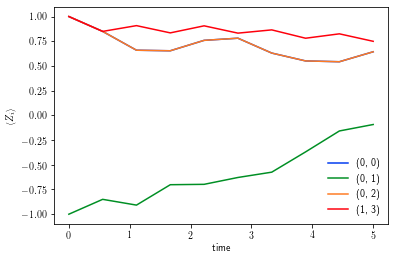

In [250]:
# plot
fig = plt.figure()
qubits = [(0, 0), (0, 1), (0, 2), (1, 3)]
for i, q in enumerate(qubits):
    site = p['W']*q[0]+q[1]
    # plt.plot(times, result[:, q[0], q[1]], label='{}'.format(q), color=colors[i])
    # Z measurement
    plt.plot(sim['Time'], sim['Zi Site {}'.format(site)], label='{}'.format(q), color=colours[i])
    # computational basis measurement
    # plt.plot(sim['Time'], 0.5*(1 - sim['Zi Site {}'.format(site)]), label='{}'.format(q), color=colours[i])
plt.xlabel('time')
plt.ylabel(r'$\langle Z_{i} \rangle$')
plt.legend();